In [1]:
import sys
sys.path.append('/autofs/homes/005/fd881/repos/MedImaging-ModelDriftMonitoring/')


In [2]:
from pathlib import Path
import pandas as pd

import click
import plotnine
from pycrumbs import tracked

from src.model_drift.data import mgb_data
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt



In [3]:
import os
os.getcwd()

'/autofs/homes/005/fd881/repos/MedImaging-ModelDriftMonitoring/src/scripts/analysis'

In [4]:
#perf_cols = [
#    col for col in df.columns
#    if  col[0].startswith('performance')
#]

In [5]:
df = pd.read_csv("/autofs/cluster/qtim/projects/xray_drift/drift_analyses/mgb_data_from_chexpert_retrain_frontal_only_lr1e-4_frozen_step25/output.csv", header=[0, 1, 2, 3])
weights = pd.read_csv('/homes/5/fd881/repos/MedImaging-ModelDriftMonitoring/models/weights/metric_weights.csv')
# The date column gets read in with a stupid name
date_col = tuple(f'Unnamed: 0_level_{i}' for i in range(4))
performance_col = ('performance', 'micro avg', 'auroc', 'mean')

df[date_col] = pd.to_datetime(df[date_col])
df.head()


Unnamed: 0_level_0 BitsStored                                              \
  Unnamed: 0_level_1       chi2                                               
  Unnamed: 0_level_2   distance                                 pval          
  Unnamed: 0_level_3       mean   median      obs           std mean median   
0         2019-07-01    28993.0  28993.0  28327.0  2.503829e-12  0.0    0.0   
1         2019-07-02    28993.0  28993.0  28591.0  3.232429e-12  0.0    0.0   
2         2019-07-03    28993.0  28993.0  28847.0  3.540949e-12  0.0    0.0   
3         2019-07-04    28993.0  28993.0  28956.0  4.002647e-12  0.0    0.0   
4         2019-07-05    28993.0  28993.0  29183.0  2.503829e-12  0.0    0.0   

              Columns  ...  performance                                \
                   ks  ... weighted avg                                 
             distance  ...    precision              recall             
   obs  std      mean  ...          obs       std      mean    median   
0  0.0  0.0  0.108212  ...     0.774798  0.023882  0.428785  0.428491   
1  0.0  0.0  0.091603  ...     0.710436  0.029434  0.413861  0.414668   
2  0.0  0.0  0.068624  ...     0.753380  0.029721  0.414670  0.414365   
3  0.0  0.0  0.075174  ...     0.760640  0.025387  0.406052  0.404781   
4  0.0  0.0  0.073103  ...     0.719013  0.035439  0.404026  0.401918   

                                                          
                                                          
                      support                             
        obs       std    mean  median     obs        std  
0  0.429840  0.015363  1668.6  1670.5   563.0  58.631229  
1  0.415669  0.013243  1536.9  1531.5   919.0  58.288665  
2  0.415340  0.011311  1622.1  1631.5  1382.0  69.780030  
3  0.407063  0.015351  1674.5  1671.0  1614.0  47.454688  
4  0.407427  0.014586  1598.1  1603.5  1885.0  59.070787  

[5 rows x 1473 columns]

In [6]:
date_col_df = df[date_col]

In [7]:
mmc_cols = [
    col for col in df.columns
    if not col[0].startswith('performance')
    and col[2] == 'distance'
    and col[3] == 'mean'
]
mmc_df = df[mmc_cols + [date_col]+ [performance_col]].copy()
ref_df_weights = mmc_df[mmc_df[date_col] < mgb_data.VAL_DATE_END].copy()
mmc_df.drop(columns=[performance_col], inplace=True)
ref_df = mmc_df[mmc_df[date_col] < mgb_data.VAL_DATE_END].copy()


In [8]:
for c in mmc_cols:
    mmc_df[c] = (mmc_df[c] - ref_df[c].mean()) / ref_df[c].std()
mmc_df['mmc'] = mmc_df.mean(axis=1)

/autofs/vast/qtim/tools/pyenv/versions/3.7.6/envs/med-image-drift/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


In [9]:
#col_to_move = ref_df.pop(date_col)
#ref_df.insert(0, date_col, col_to_move)
#ref_df.head()

In [10]:
correlation_matrix = ref_df_weights.corr()

# To get correlation with the performance column specifically
performance_correlation = correlation_matrix[performance_col]

performance_correlation_df = pd.DataFrame(performance_correlation)


In [11]:
#scale to get rid of negative values
min_weight = performance_correlation_df[performance_col].min()
max_weight = performance_correlation_df[performance_col].max()

performance_correlation_df['scaled_weights'] = (performance_correlation_df[performance_col] - min_weight) / (max_weight - min_weight)


In [12]:
# scale to the sum
total_weight = performance_correlation_df['scaled_weights'].sum()

# Divide each weight by the total sum
performance_correlation_df['scaled_weights_0_1'] = performance_correlation_df['scaled_weights'] / total_weight

In [13]:
plot_df = performance_correlation_df.reset_index()
plot_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in plot_df.columns]
plot_df.drop(columns=["level_1___", "level_2___", "level_3___"], inplace=True)
plot_df.columns = ["Metric", "Avg_F1_mean", "scaled_weights", "normalized_weights"]

In [14]:
weights= plot_df["normalized_weights"].to_list()

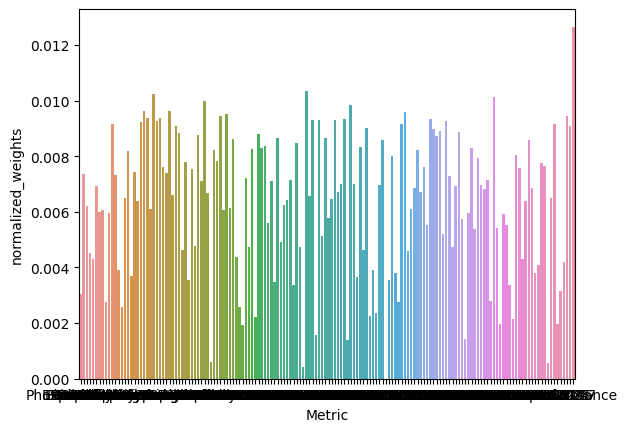

In [15]:
sn.barplot(x=plot_df.columns[0], y='normalized_weights', data=plot_df)


In [16]:
mmc_df_backup = mmc_df.copy()
mmc_df = mmc_df.iloc[:,:-2].astype(float)

In [17]:
weighted_df = mmc_df * weights[:-1]
weighted_df

,BitsStored,Columns,Exam Code,Exposure,ExposureInuAs,Is Stat,KVP,Manufacturer,Modality,Patient Age,...,mu.118,mu.119,mu.120,mu.121,mu.122,mu.123,mu.124,mu.125,mu.126,mu.127
,chi2,ks,chi2,ks,ks,chi2,ks,chi2,chi2,ks,...,ks,ks,ks,ks,ks,ks,ks,ks,ks,ks
,distance,distance,distance,distance,distance,distance,distance,distance,distance,distance,...,distance,distance,distance,distance,distance,distance,distance,distance,distance,distance
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,0.0,0.030410,-0.005072,0.008542,0.007909,0.032003,0.011292,0.015344,0.001199,0.016560,...,0.055848,0.051524,0.000552,0.016985,0.038742,0.007512,0.003165,0.010137,0.031500,0.048802
1,0.0,0.020458,-0.000889,0.007141,0.006498,0.029804,0.005922,0.011565,0.001199,0.007877,...,0.036661,0.015360,0.000022,0.027724,0.046190,0.000950,0.001155,-0.000462,0.034068,0.029724
2,0.0,0.006689,0.006354,0.007837,0.006977,0.014109,0.004087,0.009791,0.001199,0.011334,...,0.023728,0.019875,-0.000160,0.015344,0.026234,-0.000726,0.004060,0.004734,0.020589,0.026682
3,0.0,0.010614,0.002162,0.006255,0.005510,0.012344,0.004513,0.014068,0.001199,0.005955,...,0.003901,0.014622,-0.000010,0.023928,0.027031,-0.000182,0.002033,0.004359,0.015362,0.021884
4,0.0,0.009373,-0.000602,0.006076,0.005647,0.012504,-0.000159,0.011743,0.001199,0.002676,...,0.001478,0.008719,-0.000411,0.010508,0.015616,-0.000465,0.002511,0.003080,0.017238,0.022193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,0.0,0.029851,0.232992,0.007700,0.005742,0.039505,0.055086,0.152753,-0.005793,-0.003773,...,0.003500,0.081012,0.000380,0.003939,0.071677,0.026333,0.018478,0.038232,0.147361,0.122617


In [18]:
weighted_df['mmc'] = weighted_df.mean(axis=1)
weighted_df = weighted_df.join(date_col_df)

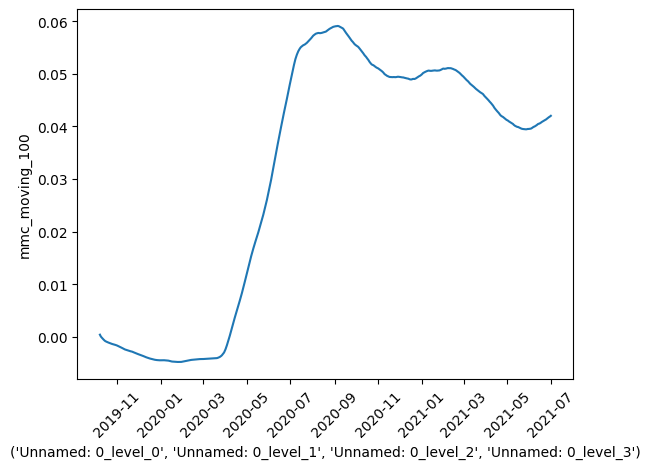

In [19]:
smoothing_window = 5

large_smoothing_window = 50
delay = round(large_smoothing_window/2)
weighted_df['mmc_moving'] = weighted_df['mmc'].rolling(window=smoothing_window).mean()
weighted_df['mmc_moving_100'] = weighted_df['mmc'].rolling(window=100).mean()

mmc_df_backup['mmc_moving'] = mmc_df_backup['mmc'].rolling(window=smoothing_window).mean()
mmc_df_backup['mmc_moving_100'] = mmc_df_backup['mmc'].rolling(window=large_smoothing_window).mean()
mmc_df_backup['filtered_adjusted'] = mmc_df_backup['mmc_moving_100'].shift(-delay)

df['auroc_moving'] = df[performance_col].rolling(window=smoothing_window).mean()


sn.lineplot(x=weighted_df[date_col], y=weighted_df['mmc_moving_100'])
plt.xticks(rotation=45)  # You can adjust the rotation angle as needed
plt.show()

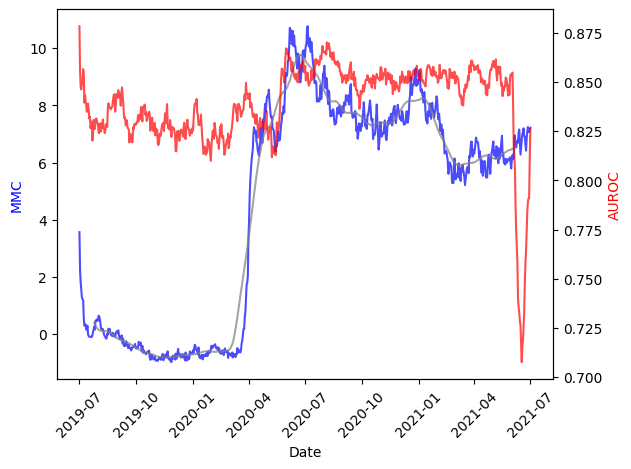

In [20]:
fig, ax1 = plt.subplots()

sn.lineplot(x=mmc_df_backup[date_col], y=mmc_df_backup['mmc'], ax=ax1, color='b', alpha=0.7)
sn.lineplot(x=mmc_df_backup[date_col], y=mmc_df_backup['filtered_adjusted'], ax=ax1, color='grey', alpha=0.7)


ax1.set_ylabel('MMC', color='b')
ax1.tick_params(axis='x', rotation=45)
ax1.set_xlabel('Date', color='black')

ax2 = ax1.twinx()

sn.lineplot(x=df[date_col], y=df[performance_col], ax=ax2, color='r', alpha=0.7)

ax2.set_ylabel('AUROC', color='r')


plt.xticks(rotation=45)  # You can adjust the rotation angle as needed
plt.show()

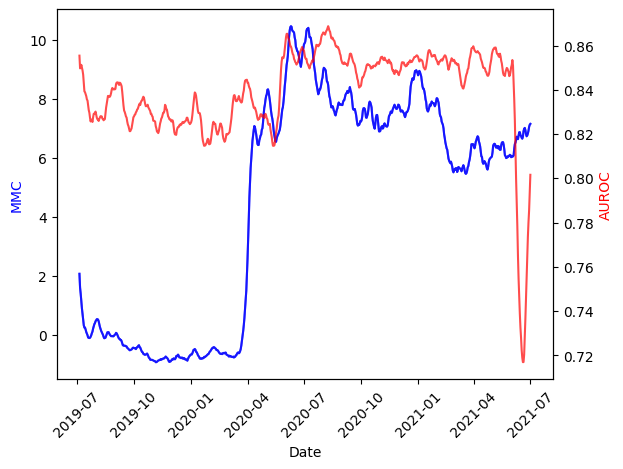

In [21]:
fig, ax1 = plt.subplots()

sn.lineplot(x=mmc_df_backup[date_col], y=mmc_df_backup['mmc_moving'], ax=ax1, color='b', alpha=0.7)
sn.lineplot(x=mmc_df_backup[date_col], y=mmc_df_backup['mmc_moving'], ax=ax1, color='b', alpha=0.7)

ax1.set_ylabel('MMC', color='b')
ax1.tick_params(axis='x', rotation=45)
ax1.set_xlabel('Date', color='black')

ax2 = ax1.twinx()

sn.lineplot(x=df[date_col], y=df['auroc_moving'], ax=ax2, color='r', alpha=0.7)
ax2.set_ylabel('AUROC', color='r')


plt.xticks(rotation=45)  # You can adjust the rotation angle as needed
plt.show()

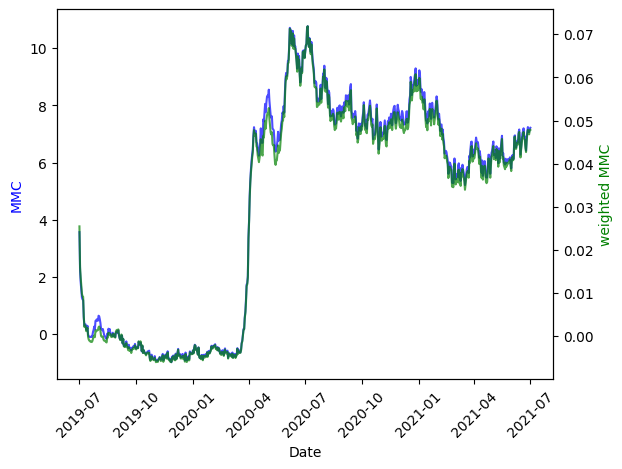

In [22]:
fig, ax1 = plt.subplots()

sn.lineplot(x=mmc_df_backup[date_col], y=mmc_df_backup['mmc'], ax=ax1, color='b', alpha=0.7)
ax1.set_ylabel('MMC', color='b')
ax1.tick_params(axis='x', rotation=45)
ax1.set_xlabel('Date', color='black')

ax2 = ax1.twinx()

sn.lineplot(x=weighted_df[date_col], y=weighted_df['mmc'], ax=ax2, color='g', alpha=0.7)
ax2.set_ylabel('weighted MMC', color='g')


plt.xticks(rotation=45)  # You can adjust the rotation angle as needed
plt.show()

No handles with labels found to put in legend.


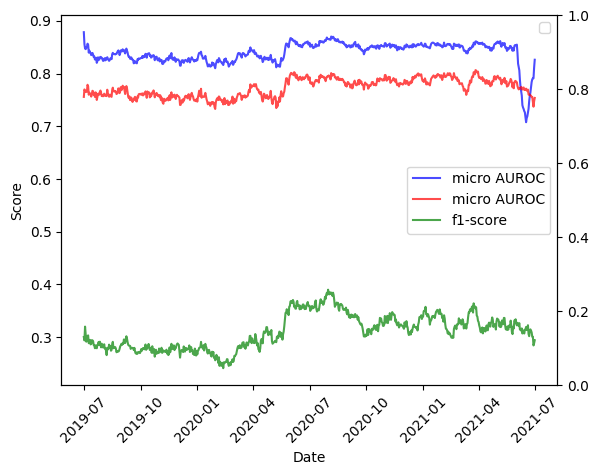

In [23]:

fig, ax1 = plt.subplots()

sn.lineplot(x=df[date_col], y=df[('performance', 'micro avg', 'auroc', 'mean')
], ax=ax1, color='b', alpha=0.7, label="micro AUROC")
ax1.set_ylabel('Score', color='black')
ax1.tick_params(axis='x', rotation=45)
ax1.set_xlabel('Date', color='black')

ax2 = ax1.twinx()

sn.lineplot(x=df[date_col], y=df[('performance', 'macro avg', 'auroc', 'mean')
], ax=ax1, color='r', alpha=0.7, label="micro AUROC")

sn.lineplot(x=df[date_col], y=df[('performance', 'macro avg', 'f1-score', 'mean')
], ax=ax1, color='g', alpha=0.7, label="f1-score")

plt.legend()

plt.xticks(rotation=45)  # You can adjust the rotation angle as needed
plt.show()